# <span style="color:red">H</span><span style="color:orange">E</span><span style="color:yellow">L</span><span style="color:green">L</span><span style="color:blue">O</span> <span style="color:violet">A</span><span style="color:blue">N</span><span style="color:green">D</span> <span style="color:yellow">W</span><span style="color:orange">E</span><span style="color:red">L</span><span style="color:orange">C</span><span style="color:yellow">O</span><span style="color:green">M</span><span style="color:blue">E</span><span style="color:violet">!</span>

***What is this notebook about?***

This is my attempt to explore my personal diary and the posibilities of knwoledge discovery.

***Methodology***

I will try to iteratively add new perspectives to this quest for meaning.

***About my diary entries***

Unfortunately, I would feel rather uncomfortable to share my dairy entries. But, I will do share all my analysis results! -which is kind of ironic when you think that if I succeed in analysing my data, I will share all my "secrets" anyways 🥴-. 

Here is some relevant information about the entries:
- I write very freely about a range of personal topics, thoughts and feelings.
- I write mostly in Spanish, some English, and some of my own language.
- I've gathered 21 months of entries so far, totaling over 60 thousand words.

### Index
1. [Data ingestion](#ingestion)
2. [Exploratory Data Analysis](#eda)
3. [References](#references)

## Analysis

<a name='ingestion'></a>
### Data ingestion


In [32]:
import os

import re
pd.set_option('display.max_colwidth', -1)

#Read contents of journal archive into list for processing
folder='data/'
list_of_journals=[]
journal_files = os.listdir(folder)
for file in journal_files:
    full_file_path=folder+file
    list_of_journals.append(full_file_path)
    
#Create DataFrame shell to load data as we parse through journal
journal_df = pd.DataFrame(columns=['year', 'date', 'entry'])

#For each file(a single year), read in data.
for full_file_path in list_of_journals:
    journal_list_of_dicts = []
    journal_dict={}
    paragraph_list = []
    previous_date='NONE'
    journal_raw = open(full_file_path)
    
    #parse out specific year from text file for use in dataframe
    year = re.search(r'(\d{4})',full_file_path).group()
    
    #Read in journal line, by line and parse our dates to associate dates with specific entry  
    for paragraph in journal_raw.readlines():
        #Use pattern matching to parse out date, input can be various formats (May 17, 5/17, 5/17/2020, etc)
        pattern = r'(\d+(\/|-|.){1}\d+(\/|-|.)?\d{0,4})|((Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s\d{1,2})'
        date_match = re.search(pattern, paragraph, re.IGNORECASE)
        if date_match and len(paragraph)<8: #length to prevent mid paragraph dates from being grabbed
            if len(journal_list_of_dicts)>0: #this is not the first instance of date, therefore we need to save date and list of paragraphs
                journal_dict = {'year':year,
                                'date': previous_date,
                                'entry': paragraph_list}
                journal_list_of_dicts.append(journal_dict)
                #save for use in next loop
                previous_date = date_match.group()
                #re_initialize list of paragraphs, and journal_dict
                paragraph_list = []
                journal_dict = {}
            else:
                if previous_date == 'NONE':
                #continue looping and save date, this is the first instance of saving a date - need to continue loop to graph paragraphs
                    previous_date = date_match.group()
                else:
                    #first instance and need to start list of dicts
                    journal_dict = {'date': previous_date,
                                    'year':year,
                                    'entry': paragraph_list}
                    journal_list_of_dicts.append(journal_dict)
                    previous_date = date_match.group(0)
                    #reset for next date
                    paragraph_list = []
                    journal_dict = {}
        else:
            #paragraph is not a date entry is continuing - must be saved to paragraph list
            paragraph_list.append(paragraph)
    #final entry
    journal_dict = {'date': previous_date,
                    'year':year,
                    'entry': paragraph_list}
    journal_list_of_dicts.append(journal_dict)
    #save to DF and concat to previous
    journal_df = pd.concat([pd.DataFrame(journal_list_of_dicts),journal_df], sort=False)

/var/folders/sd/c89_7ybj62s9w09y5w6qnvt80000gn/T/ipykernel_49444/3825419364.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [3]:
from datetime import datetime, timedelta
import numpy as np
from textblob import TextBlob
from nltk.tokenize import sent_tokenize
from textblob import Word
import contractions
import string

# Remove empty paragraphs


def clean_paragraph(entry):
    cleaned_paragraph_list = []
    for paragraph in entry:
        if paragraph != '\n':
            cleaned_paragraph_list.append(paragraph)
    return cleaned_paragraph_list


journal_df['entry'] = journal_df['entry'].apply(clean_paragraph)

# Count words and paragraphs


def word_count(entry):
    total_word_count = 0
    for paragraph in entry:
        words = len(paragraph.split())
        total_word_count = words + total_word_count
    return total_word_count


journal_df['word_count'] = journal_df['entry'].apply(word_count)
journal_df['paragraph_count'] = journal_df['entry'].apply(lambda x: len(x))

# Standardize date format


def parse_date(row):
    date = row['date']
    try:
        date = date + '.' + row['year']
        return datetime.strptime(date, '%d.%m.%Y')
    except ValueError:
        return np.nan
        
journal_df['datetime'] = journal_df.apply(lambda x: parse_date(x), axis=1)

def monthYear(row):
    try:
        monthYear = str(row['datetime'].month) + '.' + str(row['year'])
        return datetime.strptime(monthYear, '%m.%Y')
    except ValueError:
        return np.nan
    

journal_df['month'] = journal_df.apply(lambda x: monthYear(x), axis=1)
    

In [4]:
#NLLKT method: Add Column with paragraphs tokenized into sentences
def sentences_tokenized(entry):
    sent_list =[]
    for paragraph in entry:
        sent_list.append(sent_tokenize(paragraph))
    return sent_list
journal_df['sentences_tokenized'] = journal_df['entry'].apply(sentences_tokenized)

'''
Lemmatization is the process of converting a word to its base form. 
The difference between stemming and lemmatization is, 
lemmatization considers the context and converts the word to its meaningful base form, 
whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors.
Source: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#textbloblemmatizer
'''
# identify part of speech in order to pass into lemmatizer for improved context
def lemmatize_with_postag(sentence):
    sent = TextBlob(str.lower(sentence))
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return lemmatized_list

def lemmatize(entry):
    word_list = []
    #lem = WordNetLemmatizer()
    for paragraph in entry:
        #lower case
        paragraph_fixed = str.lower(paragraph)
        #fix contractions
        #see https://medium.com/@lukei_3514/dealing-with-contractions-in-nlp-d6174300876b
        paragraph_fixed = contractions.fix(paragraph_fixed)
        word_list = word_list + lemmatize_with_postag(paragraph_fixed)
    return word_list
journal_df['lemmatized_words'] = journal_df['entry'].apply(lemmatize)

#sort by date and re-index
journal_df = journal_df.sort_values('datetime', ascending=True)
journal_df = journal_df.reset_index().drop(['index'], axis=1)

<a name='eda'></a>
### Exploratory Data Analysis
#### Overall stats

In [5]:
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

style.available

#Calculate unique words / month
def unique_words_per_month(journal):
    list_of_dicts=[]
    unique_months =  list(journal.month.unique())
    for month in unique_months:
        d={}
        words_list = []
        month_mask = journal.month==month
        #original method, looking at ALL words
        for i, row in journal[month_mask].iterrows():
            for paragraph in row['sentences_tokenized']:
                for sentence in paragraph:
                    tokenized_sentence = word_tokenize(str.lower(sentence))
                    for word in tokenized_sentence:
                        if word not in words_list:
                            words_list.append(word)
        #Using lemmatized_words to count uniques - want to get a sense of uniqueness, 
        #does not make sense to count different forms of same word as a single word
        lemm_words_list=[]
        for i, row in journal[month_mask].iterrows():
            for word in row['lemmatized_words']:
                if word not in lemm_words_list:
                    lemm_words_list.append(word)
        d['month'] = month

        d['unique_words_list'] = words_list
        d['unique_words_count'] = len(words_list)
        
        d['lemm_unique_words_list'] = lemm_words_list
        d['lemm_unique_words_count'] = len(lemm_words_list)       
        
        list_of_dicts.append(d)
    return pd.DataFrame(list_of_dicts)

unique_words_by_month = unique_words_per_month(journal_df)
unique_words_by_month = unique_words_by_month.set_index('month')

#Simple aggragations for entries/words per month.
entries_per_month = journal_df['month'].value_counts().sort_index()
words_per_month = journal_df.groupby('month')['word_count'].sum()

#uniques by month calculation
unique_word_month = unique_words_by_month.sort_index()
unique_word_month = unique_words_by_month['lemm_unique_words_count']
uniques_per_total_words = unique_word_month/words_per_month
words_entry_month = words_per_month / entries_per_month


In [6]:
print('Total Words:')
print(journal_df['word_count'].sum())
print('Total Entries')
print(journal_df['year'].count())
print('Mean entries per month:')
print(entries_per_month.mean())



print('Mean words per entry:')
print(journal_df['word_count'].mean())

print('Mean words per month:')
print(journal_df.groupby('month')['word_count'].sum().mean())

Total Words:
73975
Total Entries
304
Mean entries per month:
13.590909090909092
Mean words per entry:
243.33881578947367
Mean words per month:
3346.2727272727275


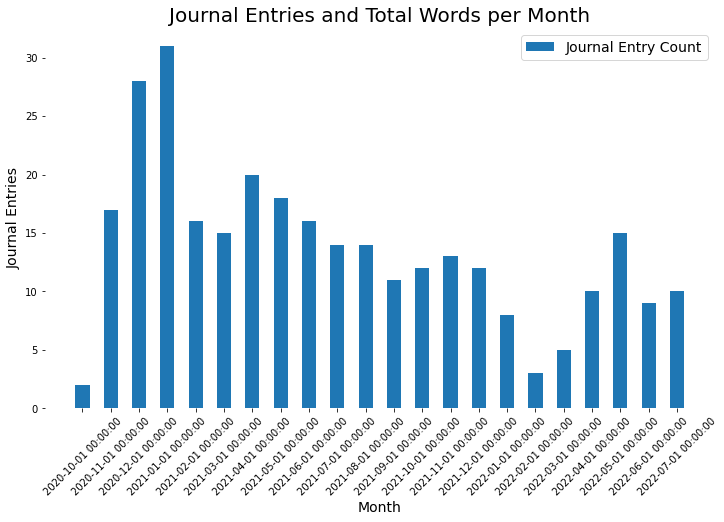

In [7]:
import matplotlib as mpl

fig, axes = plt.subplots(figsize=(12,7))
ax = entries_per_month.plot(kind='bar')
ax.set_title("Journal Entries and Total Words per Month", fontsize=20)
ax.set_xlabel('Month', fontsize=14)
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('Journal Entries', fontsize=14)
ax.legend(["Journal Entry Count"], loc='best', prop={"size":14})

#iterate through axes, to do basic formating
for i, ax in enumerate(fig.axes):
    #add comma
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    #remove spines
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    ax.xlabel = "Month"
ax.autoscale(tight=False)

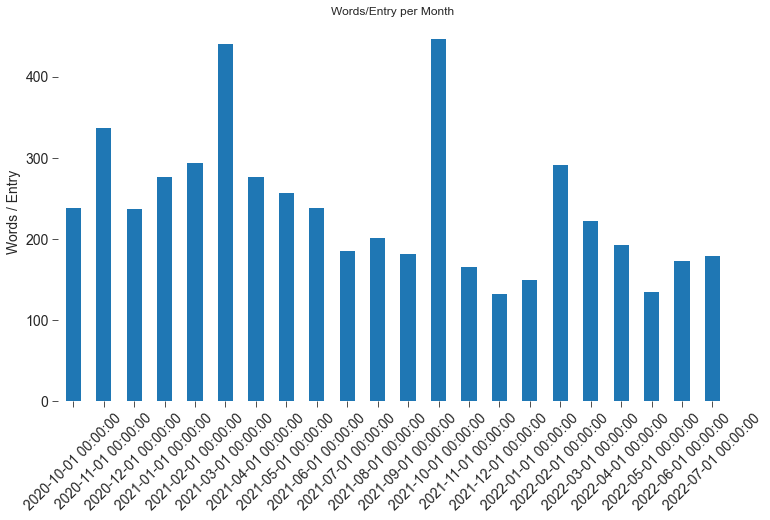

In [8]:
style.use('seaborn-ticks')
fig, axes = plt.subplots(figsize=(12,7))

ax = words_entry_month.plot(kind='bar', fontsize=14, title ="Words/Entry per Month")
ax.set_xlabel('')
ax.set_ylabel('Words / Entry', fontsize=14)
ax.tick_params(axis='x', rotation=45)

#iterate through axes, to do basic formating
for i, ax in enumerate(fig.axes):
    #add comma
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    #remove spines
    for key, spine in ax.spines.items():
        spine.set_visible(False)

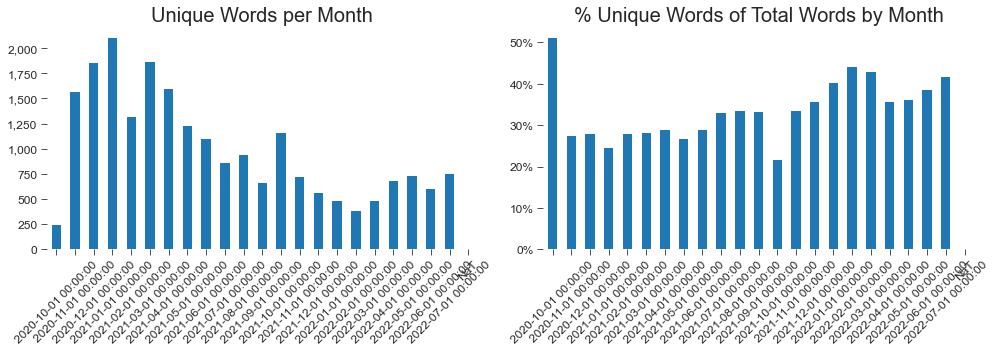

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
unique_word_month.plot(kind='bar',fontsize=12, ax=axes[0])
axes[0].set_title('Unique Words per Month', fontsize=20)
uniques_per_total_words.plot(kind='bar', fontsize=12, ax=axes[1])
axes[1].set_title('% Unique Words of Total Words by Month', fontsize=20)

#iterate through axes, to do basic formating
for i, ax in enumerate(fig.axes):
    #add comma
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    #remove spines
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)
axes[1].yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1))
fig.tight_layout()

#### Into the juicy words

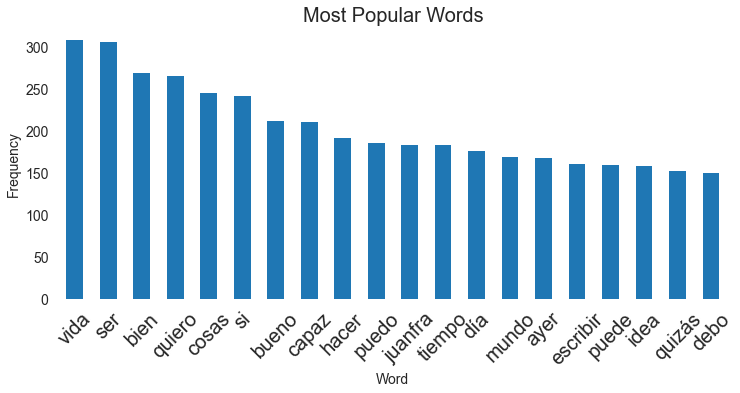

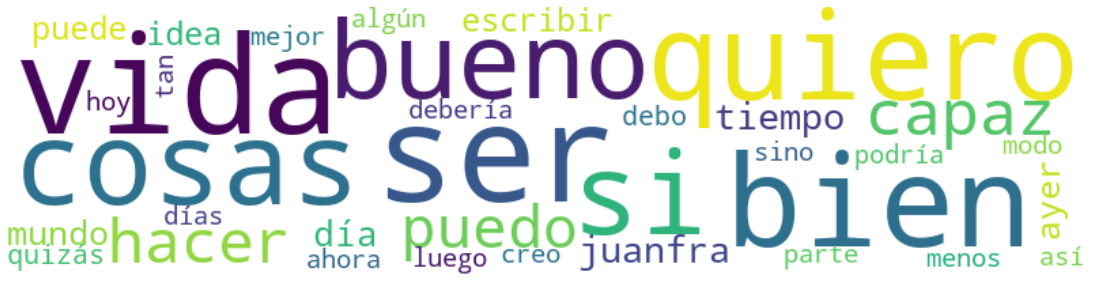

In [10]:
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud


#filter out stop words
stop_words = stopwords.words('spanish')
#Exclude puntuation
punc = string.punctuation
for thing in punc:
    stop_words.append(thing)
stop_words.append('’')
stop_words.append('”')
stop_words.append('“')

#itterate through lemmatized words, create word_list and frequency distribution
word_list =[]
for i, row in journal_df.iterrows():
    for word in row['lemmatized_words']:
        if word not in stop_words:
            word_list.append(word)
fdist = FreqDist(word_list)

#convert fdist to DF
df_fdist = pd.DataFrame.from_dict(fdist, orient='index')
df_fdist.columns = ['Frequency']
df_fdist.index.name = 'Term'
df_fdist.sort_values('Frequency', ascending=False, inplace=True)

#Visualize
chart = df_fdist.head(20).plot(kind='bar', fontsize=14, figsize=(12, 5))
plt.title("Most Popular Words", fontsize=20)
chart.set_xlabel("Word", fontsize=14)
chart.set_ylabel("Frequency", fontsize=14)
chart.tick_params(bottom=False, left=False, top=False, right=False)
for key, spine in chart.spines.items():
    spine.set_visible(False)
plt.grid(False)
plt.xticks(fontsize=20)
chart.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
chart.tick_params(axis='x', rotation=45 )
chart.get_legend().remove()
plt.show(chart)

#Create word cloud
wordcloud = WordCloud(max_words=35, max_font_size=100, width=800, height=200, margin=0, background_color = "white")
wordcloud.generate_from_frequencies(frequencies=df_fdist['Frequency'].to_dict())
plt.figure(figsize=(20,5), )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

fig.tight_layout()

In [11]:
import nltk
import textblob

stop_words=set(stopwords.words("spanish"))
pos_list_of_dicts = []

for i, row in journal_df.iterrows():
    paragraph_index = 0
    for paragraph in row['sentences_tokenized']:
        sentence_index = 0
        for sentence in paragraph:
            #remove contractions
            sentence_no_contractions = contractions.fix(sentence)
            #remove puntuation
            sentence_no_contractions = re.sub(r'[^\w\s]','',sentence_no_contractions)
            tokenized_sentence = nltk.word_tokenize(sentence_no_contractions)
            part_of_speech_phrase = nltk.pos_tag(tokenized_sentence)
            
            sentiment = TextBlob(sentence).sentiment
            polarity = sentiment[0]
            subjectivity = sentiment[1]
            lemmatized_word_list = lemmatize_with_postag(sentence_no_contractions)
            d={}
            d['sentence'] = sentence_no_contractions
            d['year']= row.year
            d['subjectivity'] = subjectivity
            d['polarity'] = polarity

            for word, lemmatized_word in zip(part_of_speech_phrase, lemmatized_word_list):
            #for word in part_of_speech_phrase:
                if word[0] not in stop_words and word[0].isalpha():
                    
                    pos_list_of_dicts.append({'word': str.lower(word[0]), 'pos': word[1], 
                                              'row_index' : i, 'paragraph_index' : paragraph_index, 
                                              'sentence_index' : sentence_index,
                                             'sentence' : sentence, 'year' : row.year,
                                             'subjectivity' : subjectivity, 'polarity' : polarity, 'lemmatized_word' : lemmatized_word})

            sentence_index += 1
        paragraph_index += 1    
pos_DF = pd.DataFrame(pos_list_of_dicts)

In [12]:
#Add mapping to pos_DF to indicate general word type
pos_lookup = {
    'NN':'noun', #	noun, singular (cat, tree)
    'NNS':'noun',#	noun plural (desks)
    'NNP':'noun',#	proper noun, singular (sarah)
    'NNPS':'noun', #proper noun, plural (indians or americans)]
    'POS' : 'noun', # possessive ending parent's'
    
    'VB': 'verb',#	verb (ask)
    'VBG': 'verb',#	verb gerund (judging)
    'VBD': 'verb',#	verb past tense (pleaded)
    'VBN': 'verb',#	verb past participle (reunified)
    'VBP': 'verb',#	verb: 'verb', present tense not 3rd person singular(wrap)
    'VBZ': 'verb', #'verb', present tense with 3rd person singular (bases)
    'MD' : 'verb', #modal could, will
    
    'JJ':'adjective',#	adjective (large)
    'JJR':'adjective',#	adjective, comparative (larger)
    'JJS':'adjective',#	adjective, superlative (largest)
    
    'FW':'foreign_word',
    
    'RB':'adverb',#	adverb (occasionally, swiftly)
    'RBR':'adverb',#	adverb, comparative (greater)
    'RBS':'adverb',#	adverb, superlative (biggest)
    
    'NNP':'proper_noun',#	proper noun, singular (sarah)
    'NNPS':'proper_noun',
    'PRP': 'proper_noun', #personal pronoun', I, he, she
    'PRP$': 'proper_noun' # possessive pronoun my, his, hers
}
pos_DF['pos_general'] = pos_DF['pos'].map(pos_lookup)

#aggregate part of speech by pos_general for easy visualization
cleaned_df = pd.DataFrame(pos_DF.groupby(['pos', 'lemmatized_word'])['pos'].count()).rename(columns={'pos':'count'}).reset_index()

nouns=[
'NN',#	noun, singular (cat, tree)
'NNS',#	noun plural (desks)
'NNP',#	proper noun, singular (sarah)
'NNPS',#proper noun, plural (indians or americans)
'POS'
]
nouns_mask = cleaned_df.pos.isin(nouns)
top_nouns = cleaned_df[nouns_mask].groupby('lemmatized_word').sum().sort_values('count', ascending=False)

verbs=[
'VB',#	verb (ask)
'VBG',#	verb gerund (judging)
'VBD',#	verb past tense (pleaded)
'VBN',#	verb past participle (reunified)
'VBP',#	verb, present tense not 3rd person singular(wrap)
'VBZ',#	verb, present tense with 3rd person singular (bases)
'MD']
verbs_mask = cleaned_df.pos.isin(verbs)
top_verbs = cleaned_df[verbs_mask].groupby('lemmatized_word').sum().sort_values('count', ascending=False)
top_verbs.head(40)


adjectives=[
    'JJ',#	adjective (large)
    'JJR',#	adjective, comparative (larger)
    'JJS'#	adjective, superlative (largest)
]
adjectives_mask = cleaned_df.pos.isin(adjectives)
top_adjectives = cleaned_df[adjectives_mask].groupby('lemmatized_word').sum().sort_values('count', ascending=False)
top_adjectives.head(40)

foreign_word=[
    'FW'
]
FW_mask = cleaned_df.pos.isin(foreign_word)
top_FW = cleaned_df[FW_mask].groupby('lemmatized_word').sum().sort_values('count', ascending=False)
top_FW.head(40)

adverbs = [
'RB',#	adverb (occasionally, swiftly)
'RBR',#	adverb, comparative (greater)
'RBS',#	adverb, superlative (biggest)
]

adverbs_mask = cleaned_df.pos.isin(adverbs)
top_adverbs = cleaned_df[adverbs_mask].groupby('lemmatized_word').sum().sort_values('count', ascending=False)
top_adverbs.head(40)

proper_nouns=[
'NNP',#	proper noun, singular (sarah)
'NNPS',#proper noun, plural (indians or americans)
#'PRP',
'PRP$'
]
proper_nouns_mask = cleaned_df.pos.isin(proper_nouns)
top_proper_nouns = cleaned_df[proper_nouns_mask].groupby('lemmatized_word').sum().sort_values('count', ascending=False)

#combine everything
top_nouns['type'] = 'noun'
top_verbs['type'] = 'verb'
top_adjectives['type'] = 'adjective'
top_adverbs['type'] = 'adverbs'
top_proper_nouns['type'] = 'proper_noun'

top_words_pos = pd.concat([top_nouns, top_verbs, top_adjectives, top_adverbs, top_proper_nouns])

NOUNS:


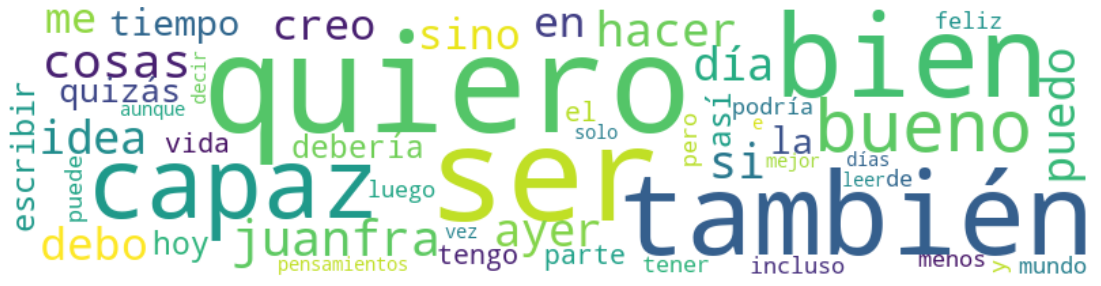

In [13]:
print('NOUNS:')
wordcloud = WordCloud(max_words=50, max_font_size=100, width=800, height=200, margin=0, background_color = "white")
wordcloud.generate_from_frequencies(frequencies=top_nouns['count'].to_dict())
plt.figure(figsize=(20,5), )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

VERBS:


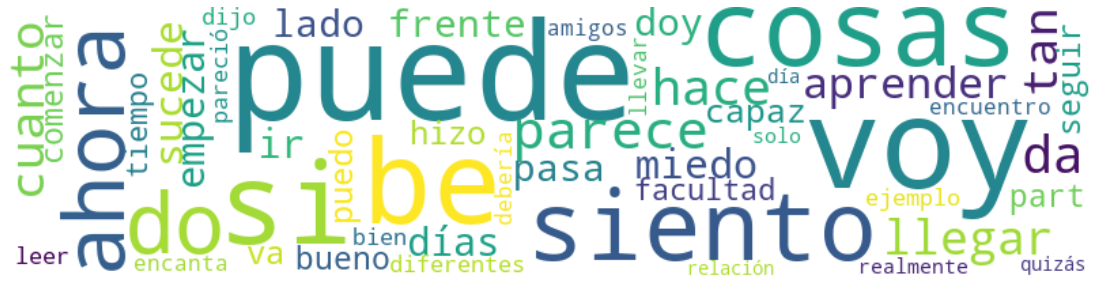

In [14]:
censor_mask = top_verbs.index!='fuck'
print('VERBS:')
wordcloud = WordCloud(max_words=50, max_font_size=100, width=800, height=200, margin=0, background_color = "white")
#wordcloud.generate_from_frequencies(frequencies=top_verbs['count'].to_dict())
wordcloud.generate_from_frequencies(frequencies=top_verbs[censor_mask]['count'].to_dict())
plt.figure(figsize=(20,5), )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

ADJECTIVES:


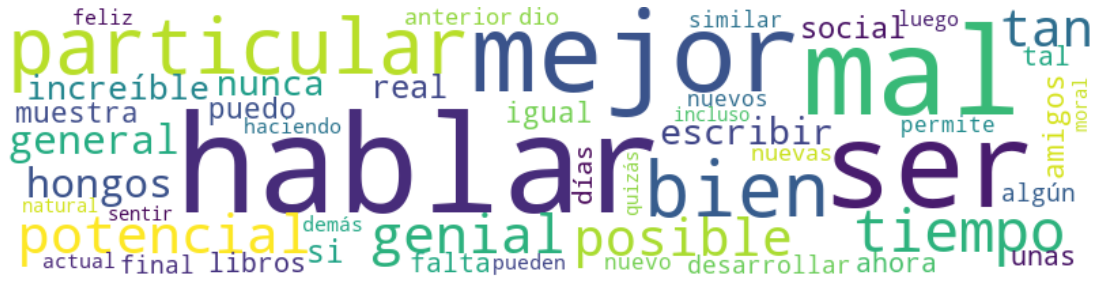

ADVERBS:


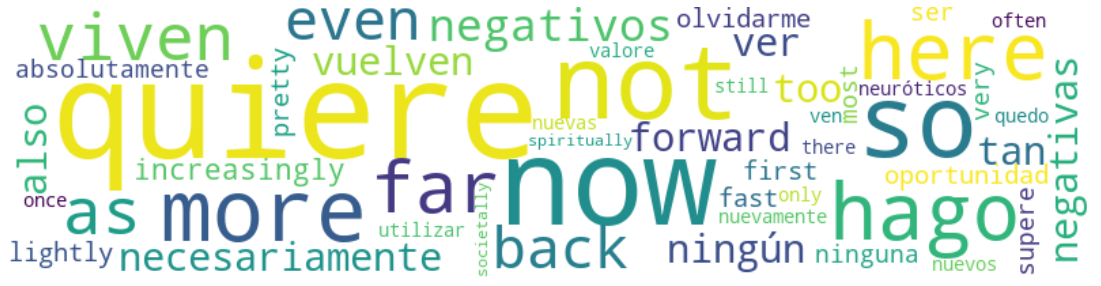

In [15]:
censor_mask = top_adjectives.index!='fucking'
print('ADJECTIVES:')
wordcloud = WordCloud(max_words=50, max_font_size=100, width=800, height=200, margin=0, background_color = "white")
wordcloud.generate_from_frequencies(frequencies=top_adjectives[censor_mask]['count'].to_dict())
plt.figure(figsize=(20,5), )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

print('ADVERBS:')
wordcloud = WordCloud(max_words=50, max_font_size=100, width=800, height=200, margin=0, background_color = "white")
wordcloud.generate_from_frequencies(frequencies=top_adverbs['count'].to_dict())
plt.figure(figsize=(20,5), )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [16]:
from nltk import ngrams
import pdb

def n_grams_function(journal_df, n=2):
    grams_list = []
    for i, row in journal_df.iterrows():
        for paragraph in row['sentences_tokenized']:
            for sentence in paragraph:
                sentence = re.sub(r'[^\w\s]','',sentence)
                tokenized_sentence = nltk.word_tokenize(str.lower(sentence))
                grammed_sentence = ngrams(tokenized_sentence, n)
                for gram in grammed_sentence:
                    grams_list.append(gram)
    grams_df = pd.DataFrame(grams_list)
    n_gram_combined_list=[]
    test = pd.DataFrame(grams_list)
    for i, row in test.iterrows():
        n_gram = ''
        for word_position in range(0,n):
            word = row.iloc[word_position]
            n_gram = n_gram + ' ' + word
        n_gram_combined_list.append(n_gram)   
    return pd.DataFrame(n_gram_combined_list)  

In [29]:
two_grams_df_with_function = n_grams_function(journal_df, n=2)
three_grams_df_with_function = n_grams_function(journal_df, n=3)
four_grams_df_with_function = n_grams_function(journal_df, n=4)
five_grams_df_with_function = n_grams_function(journal_df, n=5)




two_grams_for_plot = two_grams_df_with_function[0].value_counts()[:10]
three_grams_for_plot = three_grams_df_with_function[0].value_counts()[:10]
four_grams_for_plot = four_grams_df_with_function[0].value_counts()[:10]
five_grams_for_plot = five_grams_df_with_function[0].value_counts()[:10]

two_grams_for_plot = two_grams_df_with_function[0].value_counts()[:4]
three_grams_for_plot = three_grams_df_with_function[0].value_counts()[:4]
four_grams_for_plot = four_grams_df_with_function[0].value_counts()[:4]
five_grams_for_plot = five_grams_df_with_function[0].value_counts()[2:6]

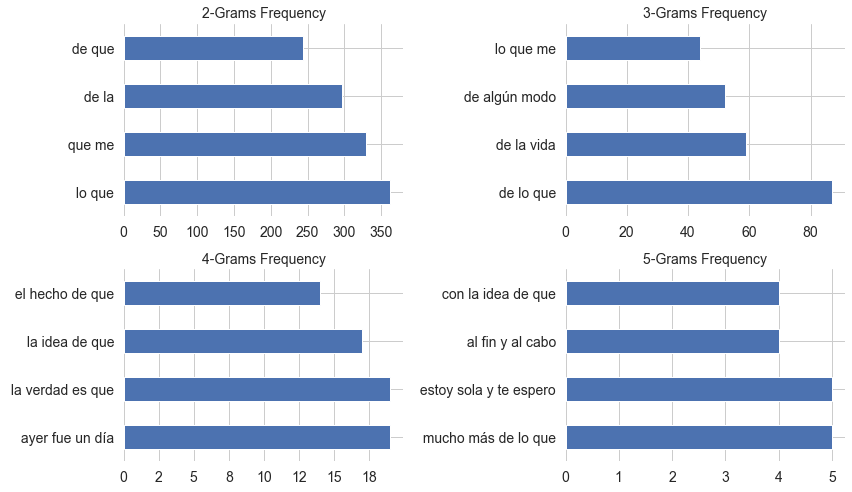

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,7))
two_grams_for_plot.plot(kind='barh',title='2-Grams Frequency', fontsize=14, ax=axes[0,0])
three_grams_for_plot.plot(kind='barh',title='3-Grams Frequency', fontsize=14, ax=axes[0,1])
four_grams_for_plot.plot(kind='barh',title='4-Grams Frequency', fontsize=14, ax=axes[1,0])
five_grams_for_plot.plot(kind='barh',title='5-Grams Frequency', fontsize=14, ax=axes[1,1])

#unique_word_year.plot(kind='bar',fontsize=12, ax=axes[0])
# axes[0].set_title('Unique Words per Year', fontsize=20)
# uniques_per_total_words.plot(kind='bar', fontsize=12, ax=axes[1])
# axes[1].set_title('% Unique Words of Total Words by Year', fontsize=20)

#iterate through axes, to do basic formating
for i, ax in enumerate(fig.axes):
    ax.title.set_size(14)
    #add comma
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    #remove spines
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    ax.set_xlabel('')
fig.tight_layout()

In [23]:
#by entry
sentiment_list = []
for i, row in journal_df.iterrows():
    #join all paragraphs into single string
    journal_entry_string = ' '.join(row['entry'])
    sentiment = TextBlob(journal_entry_string).sentiment
    polarity = sentiment[0]
    subjectivity = sentiment[1]
    d={}
    d['entry'] = journal_entry_string
    d['year']= row.year
    d['subjectivity'] = subjectivity
    d['polarity'] = polarity
    d['index'] = i
    d['datetime'] = row.datetime
    sentiment_list.append(d)
sentiment_by_entry_df = pd.DataFrame(sentiment_list)
#add calendar month column
sentiment_by_entry_df['month_integer'] = sentiment_by_entry_df['datetime'].dt.month
# try: 
#     sentiment_by_entry_df['month_name'] = sentiment_by_entry_df['month_integer'].apply(convert_to_month_name)
# except ValueError:
#     # sentiment_by_entry_df['month_name'] = sentiment_by_entry_df['month_integer'].apply(convert_to_month_name)

#by sentence
sentiment_list = []
for i, row in journal_df.iterrows():
    for paragraph in row['sentences_tokenized']:
        for sentence in paragraph:
            sentiment = TextBlob(sentence).sentiment
            polarity = sentiment[0]
            subjectivity = sentiment[1]
            d={}
            d['sentence'] = sentence
            d['year']= row.year
            d['subjectivity'] = subjectivity
            d['polarity'] = polarity
            d['index'] = i
            d['datetime'] = row.datetime
            sentiment_list.append(d)
sentiment_by_sentence_df = pd.DataFrame(sentiment_list)

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


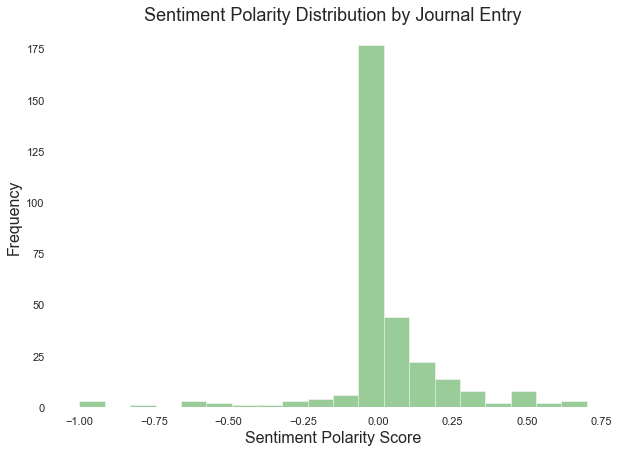

In [24]:
!pip3 install seaborn
import seaborn as sns
plt.figure(figsize=(10,7))

chart = sns.distplot(sentiment_by_entry_df['polarity'], kde=False, color='green', bins=20)
plt.title('Sentiment Polarity Distribution by Journal Entry', fontsize=18)
plt.xlabel('Sentiment Polarity Score', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

sns.set(style="whitegrid")
for key, spine in chart.spines.items():
    spine.set_visible(False)
plt.grid(False)


<a name='references'></a>
## References:

- I heavily replicated this awesome notebook: https://github.com/datachico/data_mine_journal/blob/Updated_file/NLP_on_a_diary.ipynb
- https://towardsdatascience.com/data-mine-a-diary-textblob-and-nlkt-to-analyze-your-personal-journal-a7c73f412acc
- https://towardsdatascience.com/exploring-4-5-years-of-journal-entries-with-nlp-589de6130c2d